In [42]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import MCMC, HMC, NUTS
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(3)

## Bayesian linear regression

The goal of Bayesian linear regression is to fit a linear function

$$y=w x+b+\epsilon$$

to a given dataset $D=\{(x_i,y_i)\}_{i=1,\ldots,N}$, by providing posterior probability distributions for the parameters, instead of simple point estimates. The **learnable parameters** are the weights matrix $w$ and the bias vector $b$, while $\epsilon$ is the **observation noise**.

We are going to use just NUTS inference in this notebook, with the aim of focusing our attention on how the different models are built.

**Regression from synthetic data**

In the following example we first generate synthetic data according to the equation 

$$y=2 x +3 + \mathcal{N}(0,2^2)$$

and then infer the distribution of $w$ and $b$.

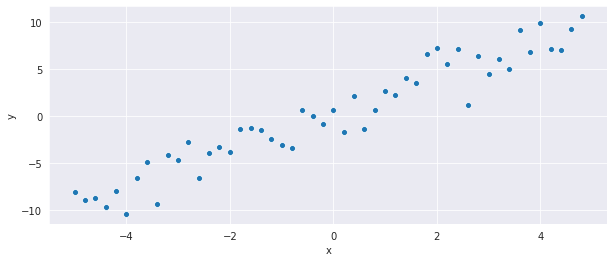

In [43]:
def generate_data():
    # set equally spaced x values between -5 and 5
    x_tensor = torch.arange(-5, 5, 0.2)
    
    # generate the corresponding y according to the equation
    y = []
    for x in x_tensor:
        noise = pyro.sample("noise", dist.Normal(torch.tensor(0.), torch.tensor(2)))
        y.append(2. * x + .3 + noise)
    
    # transform list of tensors to tensor
    y_tensor = torch.stack(y)
    
    return x_tensor, y_tensor

# generated data
x, y = generate_data()

fig, ax = plt.subplots(figsize=figsize)
ax.set(xlabel="x", ylabel="y")
sns.scatterplot(x, y);

We set normal priors on the learnable parameters $w, b\sim\mathcal{N}(0,1)$ and a uniformly distributed std for the gaussian noise on $\hat{y}$

\begin{align*}
\hat{y}&= w x + b\\
\sigma &\sim \mathcal{U}(0,1)\\
y &\sim \mathcal{N}(\hat{y},\sigma^2)
\end{align*}

then run inference on $(x,y)$ data.

In [44]:
def blr_model(x, y):
    
    w = pyro.sample("w", dist.Normal(0., 1.))
    b = pyro.sample("b", dist.Normal(0., 1.))
    
    y_hat = w * x + b
    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
    
    with pyro.plate("data", len(x)):    
        y = pyro.sample("y", dist.Normal(y_hat, sigma), obs=y)
        
kernel = NUTS(blr_model)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=200)
mcmc.run(x,y)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 300/300 [00:06, 45.20it/s, step size=7.57e-01, acc. prob=0.941]


We can now extract our posterior estimates and plot the linear fit corresponding to $x$ and $y$ observations.


estimated w = 1.9211616516113281
estimated b = 0.29073765873908997


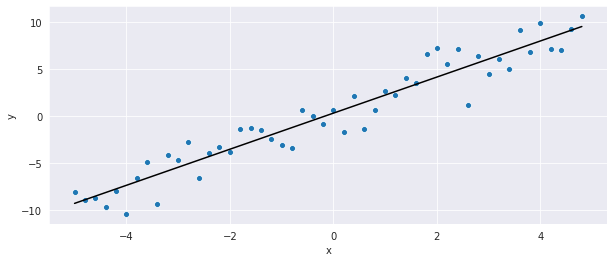

In [46]:
# extract posterior estimates
w = posterior_samples["w"].mean()
b = posterior_samples["b"].mean()
print("\nestimated w =", w.item())
print("estimated b =", b.item())

# plot regression fit
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(x, y)
ax.set(xlabel="x", ylabel="y")
sns.lineplot(x, w * x + b, color="k");

## Multiple linear regression

Multiple linear regression uses several explanatory variables $x_i$ to predict the outcome of the response variable $y$

$$ y=w_0 x_0+\ldots+w_k x_k + b + \epsilon$$

assuming there is a noise $\epsilon$ in the observations.

**Rain in Australia**

In this example we are using a dataset containing daily weather observations in Australian weather stations: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [49]:
# load data from csv and remove NA values
data = pd.read_csv('data/weatherAUS.csv').dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cl

The target variable in our MLR model is the amount of rainfall recorded for the day in Sydney and we wish to infer the parameters corresponding to the following predictors

$$
\text{Rainfall}=w_0\cdot\text{MinTemp}+w_1\cdot\text{MaxTemp}+w_2\cdot\text{Humidity9am}+\\
w_3\cdot\text{Humidity3pm}+w_4\cdot\text{Cloud9am}+w_5\cdot\text{Cloud3pm}+b + \epsilon
$$

In [50]:
# extract Sydney data 
sydney_data = data.loc[data["Location"]=="Sydney"]

# select the first 100 observations 
mlr_data = sydney_data[["Rainfall","MinTemp","MaxTemp","Humidity9am",
                        "Humidity3pm","Cloud9am","Cloud3pm"]][:100]

mlr_data.head()

,Rainfall,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm
30487,0.2,12.9,20.3,70.0,57.0,3.0,1.0
30488,0.0,13.3,21.5,75.0,58.0,2.0,5.0
30489,0.0,15.3,23.0,70.0,63.0,1.0,4.0
30493,0.2,12.9,26.7,73.0,56.0,1.0,5.0
30494,0.0,14.8,23.8,76.0,69.0,2.0,7.0


We need to convert data into torch tensors before passing it to our pyro model `sydney_mlr_model`.

In [53]:
# dataset columns to torch tensors
rain = torch.tensor(sydney_data["Rainfall"].values)
predictors = [torch.tensor(sydney_data[column].values) 
                           for column in ["MinTemp","MaxTemp","Humidity9am",
                                         "Humidity3pm","Cloud9am","Cloud3pm"]]

We set gaussian priors on all the parameters involved in this regression problem.

In [54]:
# modelling rain in terms of the predictors
def sydney_mlr_model(rain, predictors):
    
    # sample weights
    yhat = 0.
    for i, predictor in enumerate(predictors):
        w = pyro.sample(f"w_{i}", dist.Normal(0.,1.))
        yhat += w * predictor
    b = pyro.sample("b", dist.Normal(0.,1.))
    yhat += b
    
    # observations noise
    sigma = pyro.sample("sigma", dist.Normal(0.,0.5))
    
    # condition on the observations
    with pyro.plate("data", len(rain)):
        y = pyro.sample("y", dist.Normal(yhat, sigma), obs=rain)

In [55]:
kernel = NUTS(sydney_mlr_model)
mcmc = MCMC(kernel, num_samples=50, warmup_steps=100)
mcmc.run(rain, predictors)

Sample: 100%|██████████| 150/150 [02:14,  1.12it/s, step size=1.84e-02, acc. prob=0.982]


In [56]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       w_0      0.14      0.07      0.15      0.04      0.26     27.28      1.00
       w_1     -0.32      0.06     -0.33     -0.38     -0.21     17.13      1.03
       w_2      0.08      0.02      0.08      0.06      0.12     68.98      0.98
       w_3      0.04      0.02      0.04      0.01      0.07     64.59      0.99
       w_4      0.34      0.11      0.35      0.15      0.48     44.93      1.01
       w_5      0.07      0.12      0.09     -0.22      0.19     46.46      1.07
         b     -1.15      0.39     -1.03     -1.89     -0.62      4.67      1.17
     sigma      7.24      0.11      7.22      7.06      7.40     75.71      1.00

Number of divergences: 0


Boxplots are particularly useful for visualizing the posterior parameter estimates.

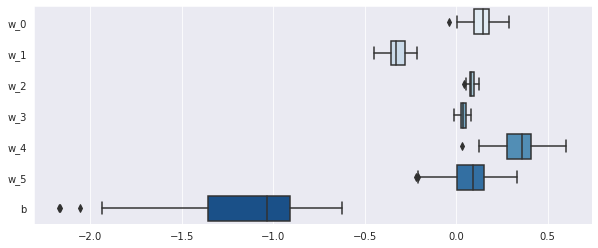

In [57]:
fig, ax = plt.subplots(figsize=figsize)
posterior_samples_df = pd.DataFrame.from_dict(mcmc.get_samples()).iloc[:,0:7]
ax = sns.boxplot(data=posterior_samples_df, orient="h",  palette="Blues");

**Matrix representation of MLR**

You could alternatively define a pyro model wich is equivalent to the previous one, by stacking all the predictors together and providing a (trivial) matrix representation of the MLR model

$$ y = \mathbf{w}\cdot\mathbf{x}+b+\epsilon,$$

where $\mathbf{w}=(w_0,\ldots,w_k)$ and $\mathbf{x}=(x_0,\ldots,x_k)$.

In [75]:
# stack all the predictors in a single matrix along the first dimension
predictors_stacked = torch.stack(predictors, dim=1)
print("matrix shape =", predictors_stacked.shape)

matrix shape = torch.Size([1690, 6])


`sydney_mlr_model_2` sets a multivariate gaussian prior over $\mathbf{w}$ and omputes the dot products $\mathbf{w}\cdot\mathbf{x}$ over the whole matrix of predictors.

In [98]:
def sydney_mlr_model_2(rain, predictors):
    n_predictors = len(predictors[1])
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors),torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    yhat = (w*predictors).sum(dim=1) + b 
    sigma = pyro.sample("sigma", dist.Normal(0.,0.5))
    
    with pyro.plate("data", len(rain)):
        y = pyro.sample("y", dist.Normal(yhat, sigma), obs=rain)

kernel = NUTS(sydney_mlr_model_2)
mcmc = MCMC(kernel, num_samples=50, warmup_steps=100)
mcmc.run(rain, predictors_stacked)

Sample: 100%|██████████| 150/150 [00:39,  3.78it/s, step size=6.15e-03, acc. prob=0.962]


In [99]:
print(mcmc.get_samples().keys())
mcmc.summary()

dict_keys(['w', 'b', 'sigma'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]      0.14      0.08      0.15      0.02      0.27     11.94      1.23
      w[1]     -0.32      0.06     -0.34     -0.39     -0.22     10.45      1.30
      w[2]      0.09      0.01      0.08      0.07      0.11     17.21      1.07
      w[3]      0.04      0.02      0.04      0.01      0.06     34.27      1.11
      w[4]      0.32      0.07      0.32      0.21      0.43     42.09      1.04
      w[5]      0.09      0.09      0.08     -0.07      0.22     26.77      1.00
         b     -1.14      0.58     -1.00     -2.06     -0.24      6.11      1.40
     sigma      7.23      0.09      7.23      7.09      7.35     61.92      0.99

Number of divergences: 0


## Logistic regression

Logistic regression is a **classification algorithm**: it predicts the probability that some given input $x$ belongs to a certain class $y$. 
This algorithm combines a multiple linear regression $\mathbf{w}^t\cdot \mathbf{x}$ on the predictors with a non-linearity on the output, corresponding to the sigmoid function $$\sigma(z)=\frac{1}{1+e^{-z}}, $$ which maps predictions to probability distributions.
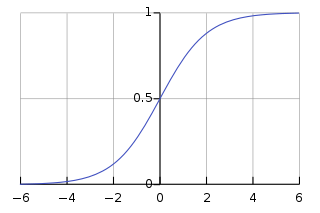
<div style="color:darkblue">https://en.wikipedia.org/wiki/Sigmoid_function</div>

Our goal in Bayesian logistic regression is to learn the conditional probability 

$$P(y|\mathbf{x},\mathbf{w}) = \sigma(\mathbf{w}^t\cdot\mathbf{x})=\frac{1}{1+e^{-(\mathbf{w}^t\cdot\mathbf{x})}}$$

by training the model on a dataset of labeled examples $(\mathbf{x},y)$.







**Predicting tomorrow's rain**

Suppose we wish to predict the binary label `RainTomorrow` from the Australian weather dataset. First, we need to replace the original labels `Yes`/`No` with boolean classification labels.

In [108]:
# select Sydney data
sydney_data = data.loc[data["Location"]=="Sydney"]

# replace labels with boolean values
print(sydney_data["RainTomorrow"].unique(), end=" ---> ")
sydney_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
print(sydney_data["RainTomorrow"].unique())

# classification labels
labels = torch.tensor(log_reg_data["RainTomorrow"].values, dtype=torch.double)

['No' 'Yes'] ---> [0 1]


Now we specify the set of predictors for our model and normalize the data, in order to guarantee better convergence properties.

In [109]:
# select predictors
df = sydney_data[["Rainfall","Humidity3pm","Cloud3pm","WindSpeed3pm",
                  "Evaporation","Pressure3pm"]]
df.head()

,Rainfall,Humidity3pm,Cloud3pm,WindSpeed3pm,Evaporation,Pressure3pm
30487,0.2,57.0,1.0,26.0,3.0,1025.6
30488,0.0,58.0,5.0,28.0,6.6,1022.4
30489,0.0,63.0,4.0,19.0,5.6,1017.8
30493,0.2,56.0,5.0,24.0,3.8,1015.0
30494,0.0,69.0,7.0,26.0,6.8,1014.7


In [116]:
# dataset normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

,Rainfall,Humidity3pm,Cloud3pm,WindSpeed3pm,Evaporation,Pressure3pm
30487,0.002119,0.552941,0.125,0.521739,0.163043,0.752381
30488,0.000000,0.564706,0.625,0.565217,0.358696,0.676190
30489,0.000000,0.623529,0.500,0.369565,0.304348,0.566667
30493,0.002119,0.541176,0.625,0.478261,0.206522,0.500000
30494,0.000000,0.694118,0.875,0.521739,0.369565,0.492857


Finally we stack the dataframe columns in a single torch tensor and perform a train-test split on the data:
- **train data** - 80% of the labeled observations will be used to perfom inference on our model
- **test data** - the remaining 20% will be used for testing the correctness of posterior predictions 

In [119]:
# torch tensor of features
features = torch.stack([torch.tensor(df[colname].values) for colname in df], dim=1)

# train-test split
k = int(0.8 * len(log_reg_data))
x_train, y_train = features[:k], labels[:k]
x_test, y_test = features[k:], labels[k:]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([1352, 6]) 
y_train.shape = torch.Size([1352])

x_test.shape = torch.Size([338, 6]) 
y_test.shape = torch.Size([338])


Now we can define our pyro model and perform inference on the training data. Notice that we sample classification labels from a **Bernoulli distribution**, because we need a binary outcomes.

In [28]:
def log_reg_model(x, y):
    n_predictors = len(x[1])
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    
    # non-linearity
    yhat = torch.sigmoid((w*x).sum(dim=1) + b)
    
    with pyro.plate("data", len(x)):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Bernoulli(yhat), obs=y)

kernel = NUTS(log_reg_model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=200)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 300/300 [00:13, 22.52it/s, step size=1.40e-01, acc. prob=0.919]


Our Bayesian logistic regression function returns a probability score between 0 and 1 on each input point $x$, which is the output of the sigmoid function. 

In order to map this value to a discrete class, `predict_class()` uses a **threshold value** of 0.5 to decide whether $x$ belongs to class $0$ or $1$. 

In [126]:
w = mcmc.get_samples()["w"].mean(0)
b = mcmc.get_samples()["b"].mean()

def predict_class(x):
    out = torch.sigmoid((w * x).sum(dim=1) + b)
    return (out>0.5)


Finally, we can count the **test accuracy** of our model, which is the percentage of correct predictions on test data.

In [127]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 73.96%


The Bayesian logistic regression model can be easily extended to the **multi-class classification** case.